In [2]:

"""
Implementation of Linear Spectral Unmixing Analysis (LSMA) for fractional roof material type

1. Load the image data (PlanetScope SuperDove 8-band w/ spectral indices)
3. Generate the PCA or MNF transformation from the imagery
4. Mask out vegetated pixels and water using NDVI
5. Perform endmember selection to for the mixture analysis
6. Run the LSMA, getting fractional cover image
7. Perform zonal statistics on OSM-ZTRAX footprint data
8. Eliminate footprints with < 90% of the appropriate roof material type

"""

# # Install required packages 
# !pip install pysptools
# !pip install multiprocess
# !pip install cvxopt

import os, sys
import geopandas as gpd
import rioxarray as rxr
import earthpy.plot as ep
import pysptools.util as sp_utils
from osgeo import gdal
from functools import partial
import multiprocess as mp
import cvxopt

print(os.getcwd())

# Coordinate Ref. System
proj = 32618  # UTM Zone 18N

print("Completed ...")

/Users/max/Library/CloudStorage/OneDrive-Personal/mcook/earth-lab/opp-urban-fuels/rooftop-materials/code
Completed ...


In [2]:

"""
Supporting functions for the OPP rooftop materials mapping project

List of function:

"""

import numpy as np
import pysptools.noise as noise
from osgeo import osr
from functools import reduce
import pysptools.abundance_maps as amap
import xarray as xr


#############
# Functions #
#############

def get_coords(frame):
    xy = frame.geometry.xy
    x = xy[0].tolist()
    y = xy[1].tolist()
    return [list(z) for z in zip(x, y)]


def array_to_tif(arr, ref, out_path, clip=False, shp=None):
    # Save the MNF transformed data as a raster
    # Transpose the new array before exporting
    in_arr = arr.transpose(2, 1, 0)
    print(in_arr.shape)
    # Assign the correct coordinates for the transposed 'y' dimension
    band_coords = range(in_arr.shape[0])
    y_coords = ref.y.values
    x_coords = ref.x.values
    # Store the new array and export
    out_arr = xr.DataArray(
        in_arr,
        dims=("band", "y", "x"),
        coords={
            "band": band_coords,
            "y": y_coords,
            "x": x_coords,
        }
    )
    # Export the new DataArray as a new GeoTIFF file
    out_arr.rio.set_crs(ref.rio.crs)  # Set the CRS
    out_arr.rio.write_transform(ref.rio.transform())  # Set the GeoTransform
    if clip is True and shp is not None:
        print("Clipping raster array ...")
        out_arr = out_arr.rio.clip(shp.geometry)
    elif clip is True and shp is None:
        print("Provide a shapefile for clipping geometry ...")
    out_arr.rio.to_raster(out_path, compress='zstd', zstd_level=1,
                          dtype='float32', driver='GTiff')  # export to GeoTIFF

    print(f"Successfully exported array to '{out_path}'")

    return out_arr


def pixel_to_xy(pixel_pairs, gt=None, wkt=None, path=None, dd=False):
    """
    Modified from code by Zachary Bears (zacharybears.com/using-python-to-
    translate-latlon-locations-to-pixels-on-a-geotiff/).
    This method translates given pixel locations into longitude-latitude
    locations on a given GeoTIFF. Arguments:
        pixel_pairs The pixel pairings to be translated in the form
                    [[x1, y1],[x2, y2]]
        gt          [Optional] A GDAL GeoTransform tuple
        wkt         [Optional] Projection information as Well-Known Text
        path        The file location of the GeoTIFF
        dd          True to use decimal degrees for longitude-latitude (False
                    is the default)

    NOTE: This method does not take into account pixel size and assumes a
            high enough image resolution for pixel size to be insignificant.
    """

    pixel_pairs = map(list, pixel_pairs)
    srs = osr.SpatialReference()  # Create a spatial ref. for dataset
    srs.ImportFromWkt(wkt)

    # Go through all the point pairs and translate them to pixel pairings
    xy_pairs = []
    for point in pixel_pairs:
        # Translate the pixel pairs into untranslated points
        lon = point[0] * gt[1] + gt[0]
        lat = point[1] * gt[5] + gt[3]
        xy_pairs.append((lon, lat)) # Add the point to our return array

    return xy_pairs


def mnf_transform(data_arr,n_components=3,nodata=-9999):
    """
        Applies the MNF rotation to a raster array; returns in HSI form
        (m x n x p). Arguments:
            rast    A NumPy raster array
            nodata  The NoData value
    """
    arr = data_arr.copy().transpose()
    arr[arr == nodata] = 0  # Remap any lingering NoData values
    # Apply the Minimum Noise Fraction (MNF) rotation
    mnf = noise.MNF()
    mnf_arr = mnf.apply(arr)
    if n_components is not None:
        return mnf_arr  # return the entire array
    else:
        print(f"Returning {n_components} components ...")
        return mnf_arr.get_components(n_components)  # return n components


def ravel_and_filter(arr, cleanup=True, nodata=-9999):
    """
    Reshapes a (p, m, n) array to ((m*n), p) where p is the number of
    dimensions and, optionally, filters out the NoData values. Assumes the
    first axis is the shortest. Arguments:
        arr      A NumPy array with shape (p, m, n)
        cleanup  True to filter out NoData values (otherwise, only ravels)
        nodata   The NoData value; only used in filtering
    """
    shp = arr.shape
    # If the array has already been raveled
    if len(shp) == 1 and cleanup:
        return arr[arr != nodata]
    # If a "single-band" image
    if len(shp) == 2:
        arr = arr.reshape(1, shp[-2]*shp[-1]).swapaxes(0, 1)
        if cleanup:
            return arr[arr != nodata]
    # For multi-band images
    else:
        arr = arr.reshape(shp[0], shp[1]*shp[2]).swapaxes(0, 1)
        if cleanup:
            return arr[arr[:,0] != nodata]
    return arr


def get_spectra(cube, coord_list, gt, wkt):
    """
    Returns the spectral profile of the pixels indicated by the indices
    provided. NOTE: Assumes an HSI cube (transpose of a GDAL raster).
    Arguments:
        hsi_cube    An HSI cube (n x m x p)
        idx         An array of indices that specify one or more pixels in a
                    raster
                    :param wkt:
                    :param gt:
                    :param coord_list:
                    :param cube:
    """

    def spectra_at_idx(data_arr, idx):
        return np.array([data_arr[p[0], p[1], :] for p in idx])

    xy_pairs = map(list, coord_list)
    srs = osr.SpatialReference()  # Create a spatial ref. for dataset
    srs.ImportFromWkt(wkt)  # Set up coord. transform.
    # Go through all the point pairs and translate them to lng-lat pairs
    pixel_pairs = []
    for point in xy_pairs:
        # Translate the x and y coordinates into pixel values
        x = (point[0] - gt[0]) / gt[1]
        y = (point[1] - gt[3]) / gt[5]
        pixel_pairs.append((int(x), int(y)))  # Add point to our return array
    # Get the pixel values at coordinates
    return spectra_at_idx(data_arr=cube.transpose(), idx=pixel_pairs)


def convex_hull_graham(points, indices=False):
    """
    Returns points on convex hull of an array of points in CCW order according
    to Graham's scan algorithm. By Tom Switzer <thomas.switzer@gmail.com>.
    Arguments:
        points      The points for which a convex hull is sought
        indices     True to return a tuple of (indices, hull)
    """
    TURN_LEFT, TURN_RIGHT, TURN_NONE = (1, -1, 0)

    def cmp(a, b):
        return (a > b) - (a < b)

    def turn(p, q, r):
        return cmp((q[0] - p[0])*(r[1] - p[1]) - (r[0] - p[0])*(q[1] - p[1]), 0)

    def keep_left(hull, r):
        while len(hull) > 1 and turn(hull[-2], hull[-1], r) != TURN_LEFT:
            hull.pop()
        if not len(hull) or hull[-1] != r:
            hull.append(r)
        return hull

    pts_sorted = sorted(points)
    l = reduce(keep_left, pts_sorted, [])
    u = reduce(keep_left, reversed(pts_sorted), [])
    hull = l.extend(u[i] for i in range(1, len(u) - 1)) or l

    if indices:
        return [points.index(h) for h in hull], hull

    return hull


def lsma(cases, members):
    # For regular LSMA with single endmember spectra
    am = amap.FCLS()
    # c is number of pixels, k is number of bands
    cc, kk = cases.shape if len(cases.shape) > 1 else (1, cases.shape[0])
    print(f"c: {cc}; k: {kk}")
    return am.map(cases.reshape((1, cc, kk)), members, normalize=False)


def partition(array, processes, axis=0):
    """
    Creates index ranges for partitioning an array to work on over multiple
    processes. Arguments:
        array           The 2-dimensional array to partition
        processes       The number of processes desired
    """
    N = array.shape[axis]
    P = (processes + 1)  # Number of breaks (number of partitions + 1)
    # Break up the indices into (roughly) equal parts
    partitions = list(zip(np.linspace(0, N, P, dtype=int)[:-1],
                          np.linspace(0, N, P, dtype=int)[1:]))
    # Final range of indices should end +1 past last index for completeness
    work_indices = partitions[:-1]
    work_indices.append((partitions[-1][0], partitions[-1][1] + 1))
    return work_indices

['index' 'class_code' 'areaUTMsqft' 'uid' 'coastal_blue' 'blue' 'green_i'
 'green' 'yellow' 'red' 'rededge' 'nir' 'ndre' 'vgnir' 'vrnir' 'ndbibg'
 'ndbirg' 'geometry']


/opt/conda/lib/python3.10/site-packages/rioxarray/raster_writer.py:130: UserWarning: The nodata value (3.402823466e+38) has been automatically changed to (3.4028234663852886e+38) to match the dtype of the data.
  warnings.warn(


Shape: (13, 7623, 6113); 
NoData Value: 3.4028234663852886e+38; 
Bands: <xarray.DataArray 'band' (band: 13)>
array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13])
Coordinates:
  * band         (band) int64 1 2 3 4 5 6 7 8 9 10 11 12 13
    spatial_ref  int64 0; 
Band Names: ('coastal_blue', 'blue', 'green_i', 'green', 'yellow', 'red', 'rededge', 'nir', 'ndre', 'vgnir', 'vrnir', 'ndbibg', 'ndbirg'); 
Data Type: float32


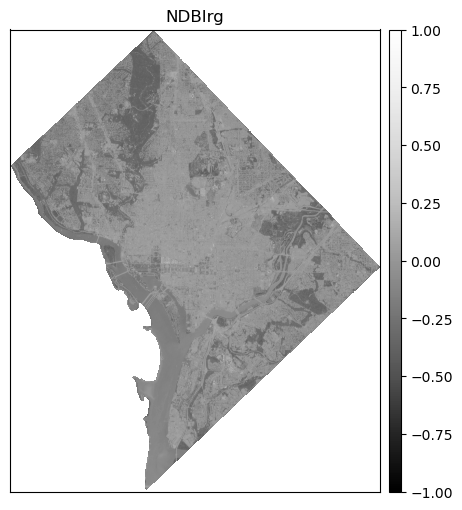

(4, 7555, 6046)


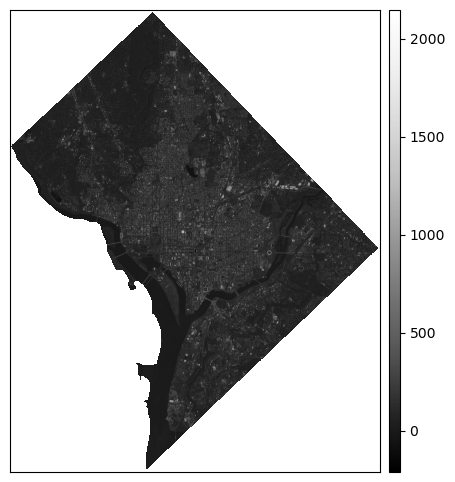

<Axes: >

In [9]:

#################
# Load the data #
#################

# County boundary
dc = gpd.read_file('/home/jovyan/district_of_columbia.gpkg').to_crs(proj)

# Read in the potential endmembers spatial data frame
ref_sp = gpd.read_file('/home/jovyan/PSScene13Band_Mosaic_DC_reference.gpkg')
ref_sp = ref_sp.to_crs(proj)  # ensure the correct projection
print(ref_sp.columns.values)

# Bring in the image file and get the projection information
image_path = '/home/jovyan/20220605_PSScene13B_Mosaic_DC.tif'
stack = rxr.open_rasterio(image_path,masked=True).rio.reproject(proj)
print(
    f"Shape: {stack.shape}; \n"
    f"NoData Value: {stack.rio.nodata}; \n"
    f"Bands: {stack.band}; \n"
    f"Band Names: {stack.long_name}; \n"
    f"Data Type: {stack[0].dtype}")
# Plot one image as an example (green band)
ep.plot_bands(
    stack[12],
    scale=False,
    vmin=-1,vmax=1,
    title="NDBIrg",
    figsize=(6,6))

# Load the MNF-transformed raster array
mnf_path = '/home/jovyan/psscene_mnf_transform.tif'
stack_mnf = rxr.open_rasterio(mnf_path).squeeze()
print(stack_mnf.shape)
# Plot the first MNF
ep.plot_bands(stack_mnf[0],figsize=(6,6))


In [10]:
# Grab projection information
# Get the WKT and GeoTransform
gdal.UseExceptions()  # Enable errors
try:
    ds = gdal.Open(image_path)
    gt = ds.GetGeoTransform()
    wkt = ds.GetProjection()
except RuntimeError:  # <- Check first what exception is being thrown
    pass
del ds
print(f"GeoTransform: {gt}; \nWKT: {wkt}")

GeoTransform: (316167.0, 3.0, 0.0, 4318398.0, 0.0, -3.0); 
WKT: PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


Roofing Material Types: ['CS' 'ME' 'SL' 'UR' 'TL' 'WS' 'SH']
Starting endmember extraction for CS


/opt/conda/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:186: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Mask: /home/jovyan/CS_mask.tif; 
Shape: (7555, 6046); 
NoData: None; 
Type: <class 'xarray.core.dataarray.DataArray'>DType: uint16


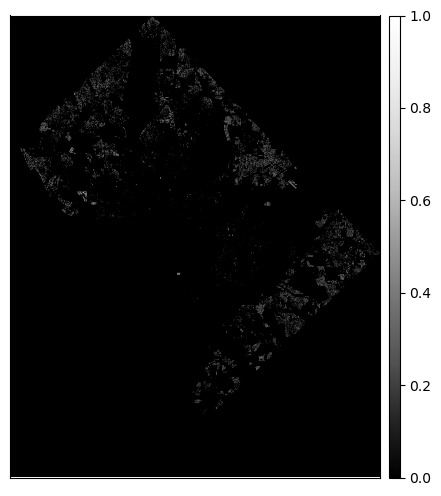

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(7555, 6046)
Pixel Purity Index Results: [[nan nan nan]]
Starting endmember extraction for ME


/opt/conda/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:186: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Mask: /home/jovyan/ME_mask.tif; 
Shape: (7555, 6046); 
NoData: None; 
Type: <class 'xarray.core.dataarray.DataArray'>DType: uint16


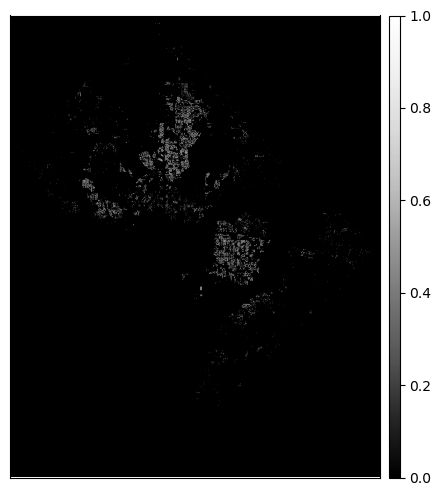

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(7555, 6046)
Pixel Purity Index Results: [[nan nan nan]]
Starting endmember extraction for SL


/opt/conda/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:186: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Mask: /home/jovyan/SL_mask.tif; 
Shape: (7555, 6046); 
NoData: None; 
Type: <class 'xarray.core.dataarray.DataArray'>DType: uint16


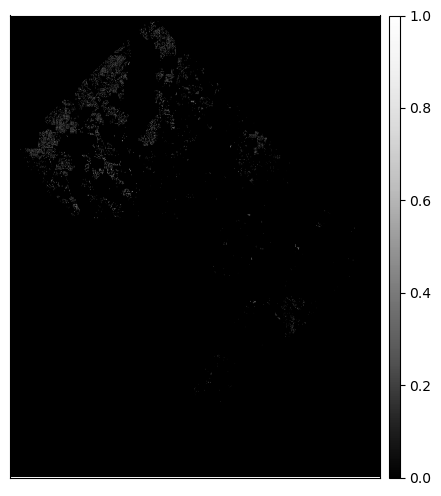

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(7555, 6046)
Pixel Purity Index Results: [[nan nan nan]]
Starting endmember extraction for UR


/opt/conda/lib/python3.10/site-packages/xarray/core/duck_array_ops.py:186: RuntimeWarning: invalid value encountered in cast
  return data.astype(dtype, **kwargs)


Mask: /home/jovyan/UR_mask.tif; 
Shape: (7555, 6046); 
NoData: None; 
Type: <class 'xarray.core.dataarray.DataArray'>DType: uint16


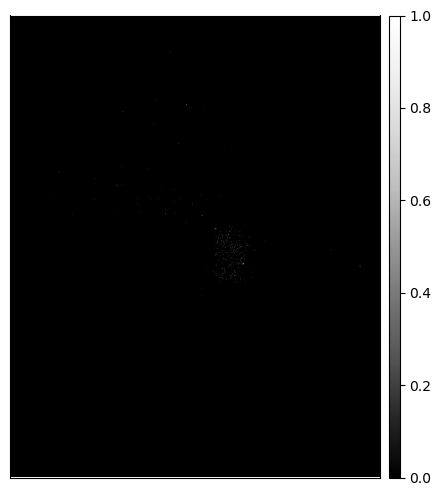

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(7555, 6046)


KeyboardInterrupt: 

In [104]:
import pysptools.eea as eea
import glob

# Load the roof type masks
masks_dir = 'data/spatial/mod/dc_data/unmixed/masks/'
masks = glob.glob(os.path.join('/home/jovyan/', '*{}'.format('.tif')), recursive=False)

# Grab the class codes
groups = ref_sp['class_code'].unique()
print(f"Roofing Material Types: {groups}")

ems = []
for i in range(len(groups)):
    group = groups[i]
    print(f"Starting endmember extraction for {group}")
    # Get a list of roof type masks
    mask_path = list(filter(lambda x: group in x, masks))
    # Open the corresponding mask
    mask = rxr.open_rasterio(mask_path[0], masked=True, cache=False).squeeze()
    mask = mask.rio.clip(dc.geometry).astype(np.uint16)
    print(f"Mask: {mask_path[0]}; \n"
          f"Shape: {mask.shape}; \n"
          f"NoData: {mask.rio.nodata}; \n"
          f"Type: {type(mask)}"
          f"DType: {mask.dtype}")
    ep.plot_bands(mask, figsize=(6,6))
    
    # mask_ = mask.to_numpy().astype(np.int16)
    # # mask_ = np.isnan(mask_)
    # print(mask_)
    # print(mask_.shape)

    # Mask the input MNF array stack to footprints
    stack_mnf_ = stack_mnf[:3,:,:]
    stack_mnf_ = stack_mnf_.where(mask == 1)
    # stack_mnf_ = stack_mnf_.fillna(0)

    # Set up the EEA
            
    ppi = eea.PPI()
    ppi_ems = ppi.extract(np.asarray(stack_mnf_.T), q=1, numSkewers=2000)
    print(f"Pixel Purity Index Results: {ppi_ems}")
    ems.append(ppi_ems)

# Concatenate the arrays of endmembers
ems = np.concatenate(ems)
print(ems.shape)

In [60]:
print(f"Endmember array: \n{np.asarray(ems)} \nShape: {ems.shape} \nType: {type(ems)}")

Endmember array: 
[[1613.5637     292.4473    -111.33099  ]
 [1601.5753    -231.49759    401.54855  ]
 [ 919.85065    176.18713    -19.654533 ]
 [ 716.26013    148.8652      -7.2650146]
 [ 709.0379     137.12294    -17.348602 ]
 [ 539.32837    111.006325     6.8677382]
 [ 724.77057    223.38033     -3.7478216]] 
Shape: (7, 3) 
Type: <class 'numpy.ndarray'>


In [61]:
ems_arr = np.array(
    [[1613.5637, 292.4473, -111.33099],
     [1601.5753, -231.49759, 401.54855],
     [919.85065, 176.18713, -19.654533],
     [716.26013, 148.8652, -7.2650146],
     [709.0379, 137.12294, -17.348602],
     [539.32837, 111.006325, 6.8677382],
     [724.77057, 223.38033, -3.7478216]])

In [59]:
test = np.asarray([[-6.51688016e+01,  7.03464253e+00,  4.45305339e+01],
       [-3.70557903e+01, -6.52316642e+01, -1.60292982e+01],
       [ 1.54686725e+01, -8.62839005e+01, -3.11055861e+00],
       [ 7.58711959e+01, -1.00056840e+02,  4.98703330e+00],
       [ 9.11216756e+02,  2.01983923e+01,  3.05698571e+02],
       [ 1.36291754e+03,  2.10442195e+02, -1.34513019e+00],
       [ 1.20291477e+03,  2.92121455e+02, -9.38859610e+01]])
print(test)
print(test.shape)
print(type(test))

[[-6.51688016e+01  7.03464253e+00  4.45305339e+01]
 [-3.70557903e+01 -6.52316642e+01 -1.60292982e+01]
 [ 1.54686725e+01 -8.62839005e+01 -3.11055861e+00]
 [ 7.58711959e+01 -1.00056840e+02  4.98703330e+00]
 [ 9.11216756e+02  2.01983923e+01  3.05698571e+02]
 [ 1.36291754e+03  2.10442195e+02 -1.34513019e+00]
 [ 1.20291477e+03  2.92121455e+02 -9.38859610e+01]]
(7, 3)
<class 'numpy.ndarray'>


In [69]:
print(f"MNF array: {np.asarray(stack_mnf).shape}; \nTransposed: {np.asarray(stack_mnf.T).shape}; \nType: {type(stack_mnf)}")
print(np.isnan(np.asarray(stack_mnf)))
stack_mnf_ = stack_mnf[:3,:,:]
stack_mnf_ = np.nan_to_num(stack_mnf_)
print(stack_mnf_.shape)
print(stack_mnf_.dtype)
print(ems.dtype)

MNF array: (4, 7555, 6046); 
Transposed: (6046, 7555, 4); 
Type: <class 'xarray.core.dataarray.DataArray'>
[[[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  ...
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]
  [ True  True  True ...  True  True  True]]

 [[ True  True  True ...  True  True  True]
  [ True  True  True ...  True  T

In [122]:
#########################
# Manual(ish) Endmember #
#########################
import pandas as pd
ems_rand = pd.read_csv('/home/jovyan/ref_ems_rand.csv')
print(ems_rand)

size = 1        # sample size
replace = True  # with replacement
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]
ems_rand_ = ems_rand.groupby('class_code', as_index=False).apply(fn)
print(ems_rand_)

ems_rand_arr = np.asarray(ems_rand_[['mnf_1','mnf_2','mnf_3']])
print(ems_rand_arr)

# spectra = np.asarray(ems_rand['class_code'])
# ems_arrs = np.asarray(ems_rand[['mnf_1','mnf_2','mnf_3']])

# mems = tuple([spectra,ems_arrs])
# print(mems)

# cases, endmembers = mems
# print("Cases: ")
# print(cases.shape)
# print(cases)

# c, k = cases.shape if len(cases.shape) > 1 else (1, cases.shape[0])
# print(c)
# print(k)

       fid class_code  areaUTMsqft       uid       mnf_1       mnf_2   
0     1204         SL  1820.201553    1204SL    8.612404  -39.916702  \
1     3823         UR  2054.628222    3823UR  118.152733   14.120766   
2     4039         TL  2924.439056    4039TL   39.108730  -30.760288   
3     4879         TL  1833.162165    4879TL   94.844414   -9.013674   
4     5904         SH  2801.814700    5904SH   56.009434  -24.726057   
..     ...        ...          ...       ...         ...         ...   
65  119216         ME  2452.673863  119216ME  323.451447   61.288284   
66  119643         WS  2724.146314  119643WS  223.819656   25.515818   
67  119824         UR  1708.296318  119824UR  325.500336   65.053688   
68  120103         ME  1773.900677  120103ME  623.986206  130.495590   
69  120794         WS  2155.128435  120794WS   92.023651  -29.012978   

        mnf_3      mnf_4  
0  -10.274023   8.547749  
1    5.825868  -7.297493  
2   -5.937073   8.581010  
3    7.645008  -5.517813  


In [130]:

rand_ems_arr = np.asarray(
    [[34.97876358, -10.00239944, -10.8166151],
     [430.99594116, 86.87063599, 9.27018929],
     [56.00943375, -24.72605705, -8.31246281],
     [78.94448853, -46.61688232, -2.54516935],
     [159.65684509, 14.71893597, 5.58152342],
     [261.29370117, 46.31309509, -0.85816938],
     [92.02365112, -29.0129776, -5.6692729]])

stack_mnf_ = np.asarray(stack_mnf)
stack_mnf_ = np.nan_to_num(stack_mnf_)

############################################
# Fully Constrained Least Squares Unmixing #
# Linear Spectral Mixture Analysis (LSMA)  #
# Single endmember per group               #
############################################

import time
import traceback

num_processes = mp.cpu_count() - 1
print(f"Splitting across {num_processes} chunks for work ...")

# Check the data shapes
print(f"Image array (MNF) shape: {stack_mnf_.shape}; Endmember array shape: {rand_ems_arr.shape}")

# Split the MNF-transformed stack into chunks to be processed by each process
chunks = np.array_split(stack_mnf_[:3,:,:], num_processes, axis=2)

# Perform FCLS unmixing in parallel
start_time = time.time()
if __name__ == '__main__':
    
    # Function to parallelize FCLS unmixing
    def parallel_fcls_unmixing(chunk, endmembers):
        try:
            am = amap.FCLS()
            return am.map(chunk.T, endmembers, normalize=False)
        except Exception as e:
            traceback.print_exc()
            raise e
    
    with mp.Pool(processes=num_processes) as pool:
        try:
            unmix_results = pool.map(partial(parallel_fcls_unmixing, endmembers=rand_ems_arr), chunks)
            pool.close()
        except Exception as e:
            traceback.print_exc()
            raise e
        finally:
            pool.terminate()
            pool.join() 
            
print(f"Time elapsed: {round(time.time() - start_time, 1)} seconds.") 


Splitting across 31 chunks for work ...
Image array (MNF) shape: (4, 7555, 6046); Endmember array shape: (7, 3)
Time elapsed: 8375.3 seconds.


In [131]:
# Retrieve the results
print(type(unmix_results))
print(len(unmix_results))
# Combine the FCLS results from all chunks back into a single array
ams_combined_parallel = np.concatenate(unmix_results)
print(f"Final combined array shape: {ams_combined_parallel.shape}")

<class 'list'>
31
Final combined array shape: (6046, 7555, 7)


In [132]:
print(gt, wkt)

(316167.0, 3.0, 0.0, 4318398.0, 0.0, -3.0) PROJCS["WGS 84 / UTM zone 18N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-75],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32618"]]


In [133]:
###############################
# Dump raster, export GeoTIFF #
###############################

from osgeo import gdal, gdal_array

def dump_raster(rast, rast_path, driver='GTiff', gdt=None, nodata=None):
    """
    Creates a raster file from a given gdal.Dataset instance. Arguments:
        rast        A gdal.Dataset; does NOT accept NumPy array
        rast_path   The path of the output raster file
        driver      The name of the GDAL driver to use (determines file type)
        gdt         The GDAL data type to use, e.g., see gdal.GDT_Float32
        nodata      The NoData value; defaults to -9999.
    """
    if gdt is None:
        gdt = rast.GetRasterBand(1).DataType
    driver = gdal.GetDriverByName(driver)
    sink = driver.Create(
        rast_path, rast.RasterXSize, rast.RasterYSize, rast.RasterCount, int(gdt))
    assert sink is not None, 'Cannot create dataset; there may be a problem with the output path you specified'
    sink.SetGeoTransform(rast.GetGeoTransform())
    sink.SetProjection(rast.GetProjection())
    
    for b in range(1, rast.RasterCount + 1):
        dat = rast.GetRasterBand(b).ReadAsArray()
        sink.GetRasterBand(b).WriteArray(dat)
        sink.GetRasterBand(b).SetStatistics(*map(np.float64,
            [dat.min(), dat.max(), dat.mean(), dat.std()]))

        if nodata is None:
            nodata = rast.GetRasterBand(b).GetNoDataValue()

            if nodata is None:
                nodata = -9999

        sink.GetRasterBand(b).SetNoDataValue(np.float64(nodata))

    sink.FlushCache()
    
def array_to_raster(a, gt, wkt, xoff=None, yoff=None, dtype=None):
    """
    Creates a raster from a given array, with optional x- and y-offsets
    if the array was clipped. Arguments:
        a       A NumPy array
        gt      A GDAL GeoTransform tuple
        wkt     Well-Known Text projection
        xoff    The offset in the x-direction; should be provided when clipped
        yoff    The offset in the y-direction; should be provided when clipped
        dtype   The data type to coerce on the array
    """
    if dtype is not None:
        a = a.astype(dtype)
    try:
        rast = gdal_array.OpenNumPyArray(a)
    except AttributeError:
        # For backwards compatibility with older version of GDAL
        rast = gdal.Open(gdalnumeric.GetArrayFilename(a))
    except:
        rast = gdal_array.OpenArray(a)
    rast.SetGeoTransform(gt)
    rast.SetProjection(wkt)
    if xoff is not None and yoff is not None:
        # Bit of a hack; essentially, re-create the raster but with the
        #   correct X and Y offsets (don't know how to do this without the
        #   use of CopyDatasetInfo())
        return array_to_raster_clone(a, rast, xoff, yoff)
    return rast

In [75]:
# Bring in the image file and get the projection information
image_path = '/home/jovyan/20220605_PSScene13B_Mosaic_DC.tif'
stack = rxr.open_rasterio(image_path,masked=True)
stack = stack.rio.reproject(proj)

In [137]:
# Export the abundance ndarray as a multiband raster
import xarray as xr

print(f"Original shape: {stack_mnf.shape}; \nAbundance maps shape: {ams_combined_parallel.shape}")
print(f"Length of 'y' attribute: {stack_mnf.y}; \nLength of shape[1]: {ams_combined_parallel.shape[1]}")

# Transpose the new array before exporting
in_arr = ams_combined_parallel.transpose(2, 1, 0)
print(in_arr.shape)

# Assign the correct coordinates for the transposed 'y' dimension
band_coords = range(in_arr.shape[0])
y_coords = stack_mnf.y.values
x_coords = stack_mnf.x.values

# Store the new array and export
out_arr = xr.DataArray(
    in_arr,
    dims=("band", "y", "x"),
    coords={
        "band": band_coords,
        "y": y_coords,
        "x": x_coords,
    }
)

# Export the new DataArray as a new GeoTIFF file
# Assign projection information
out_arr.rio.set_crs(stack_mnf.rio.crs)  # Set the CRS
out_arr.rio.write_transform(stack_mnf.rio.transform())  # Set the GeoTransform
out_arr = out_arr.rio.clip(dc.geometry)  # clip to DC county
output_path = "fcls_abundances_manual.tif"
out_arr.rio.to_raster(output_path, compress='zstd', zstd_level=1,
                      dtype='float32', driver='GTiff')  # export to GeoTIFF
print("Success !! ...")

Original shape: (4, 7555, 6046); 
Abundance maps shape: (6046, 7555, 7)
Length of 'y' attribute: <xarray.DataArray 'y' (y: 7555)>
array([4318294.5, 4318291.5, 4318288.5, ..., 4295638.5, 4295635.5, 4295632.5])
Coordinates:
  * y            (y) float64 4.318e+06 4.318e+06 ... 4.296e+06 4.296e+06
    spatial_ref  int64 0; 
Length of shape[1]: 7555
(7, 7555, 6046)
Success !! ...


Class 0: CS
Class 1: ME
Class 2: SL
Class 3: UR
Class 4: TL
Class 5: WS
Class 6: SH


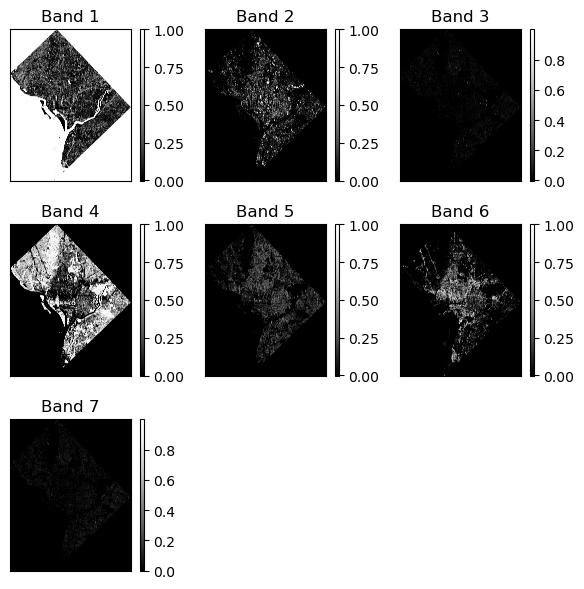

array([[<Axes: title={'center': 'Band 1'}>,
        <Axes: title={'center': 'Band 2'}>,
        <Axes: title={'center': 'Band 3'}>],
       [<Axes: title={'center': 'Band 4'}>,
        <Axes: title={'center': 'Band 5'}>,
        <Axes: title={'center': 'Band 6'}>],
       [<Axes: title={'center': 'Band 7'}>, <Axes: >, <Axes: >]],
      dtype=object)

In [136]:
# Test the output array by plotting the first abundance map
for i in range(len(groups)):
    print(f"Class {i}: {groups[i]}")
ep.plot_bands(
    ams_combined_parallel.T,
    scale=False,
    figsize=(6,6))